Deep Learning Project

Semantic Segmentation of epithel of low blood supply using U-net.

Start of with importing libraries

In [1]:
import os
import sys
import random
import warnings
import torch
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
import cv2
import keras
import scipy.misc

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import data, io, filters

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing import image

from PIL import Image
from scipy import ndimage
from sklearn import manifold, datasets
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import chain

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seeed = 42
#random.seed = seeed
#np.random.seed() = seeed

print("Imported all libraries and dependencies")

Using TensorFlow backend.


Imported all libraries and dependencies


1. Preparing data

In [35]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# set paths
TRAIN_PATH = 'C:/Users/Kristian/Downloads/U-Net/data/train/' #enter path to training data
TEST_PATH = 'C:/Users/Kristian/Downloads/U-Net/data/test/' #enter path to testing data

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

print(train_ids)
print(test_ids)

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print("X_train",X_train.shape)
print("Y_train",Y_train.shape)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/image/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/mask/'))[2]:
        mask_ = imread(path + '/mask/' + mask_file)
        mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask
    
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/image/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/mask/'))[2]:
        mask_ = imread(path + '/mask/' + mask_file)
        mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_test[n] = mask
    

print('Done!')

['1', '2', '3', '4', '5', '6', '7']
['1']
X_train (7, 128, 128, 3)
Y_train (7, 128, 128, 1)
Getting and resizing train images and masks ... 


100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Getting and resizing test images ... 


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Done!


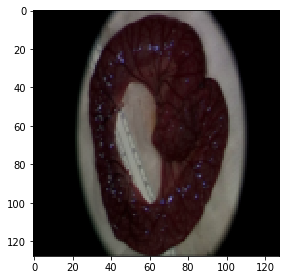

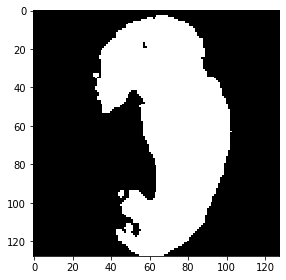

In [37]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids)-1)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

2. Data augmentation

In [38]:
from keras.preprocessing import image
BATCH_SIZE = 8 # the higher the better

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=360, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=360, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seeed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seeed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seeed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seeed)


# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seeed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seeed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seeed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seeed)

print('Done!')

Done!


In [39]:
#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)
print('Done!')

Done!


3. Creating the U-net model




Defining the intersection over union (IOU). What's common for A and B, over what's total for A and B.

In [40]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
print('Done!')

Done!


In [41]:
#def U_net(self):
# Build U-Net model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

#return model

print('Done!')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 128, 128, 16) 0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 

4. Training

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('U-net', verbose=1, save_best_only=True)

# If ran without data augmentation
#results = model.fit(X_train, Y_train, validation_split=0.1, batch_size = 16, epochs=50, callbacks=[earlystopper, checkpointer], verbose=2)

# If ran with data augmentation
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250, epochs=3, callbacks=[earlystopper, checkpointer])

print('Done!')

Epoch 1/3
223/250 [=========================>....] - ETA: 23:16 - loss: 0.7715 - mean_iou: 0.0000e+0 - ETA: 13:44 - loss: 0.7520 - mean_iou: 0.1700    - ETA: 10:45 - loss: 0.7224 - mean_iou: 0.232 - ETA: 9:12 - loss: 0.6935 - mean_iou: 0.262 - ETA: 8:19 - loss: 0.6593 - mean_iou: 0.28 - ETA: 7:42 - loss: 0.6158 - mean_iou: 0.29 - ETA: 7:18 - loss: 0.6369 - mean_iou: 0.31 - ETA: 7:01 - loss: 0.5951 - mean_iou: 0.32 - ETA: 6:48 - loss: 0.5950 - mean_iou: 0.33 - ETA: 6:39 - loss: 0.5687 - mean_iou: 0.35 - ETA: 6:25 - loss: 0.5524 - mean_iou: 0.36 - ETA: 6:14 - loss: 0.5404 - mean_iou: 0.37 - ETA: 6:04 - loss: 0.5278 - mean_iou: 0.37 - ETA: 5:55 - loss: 0.5145 - mean_iou: 0.38 - ETA: 5:50 - loss: 0.5012 - mean_iou: 0.39 - ETA: 5:43 - loss: 0.4860 - mean_iou: 0.40 - ETA: 5:35 - loss: 0.4739 - mean_iou: 0.40 - ETA: 5:29 - loss: 0.4665 - mean_iou: 0.41 - ETA: 5:23 - loss: 0.4567 - mean_iou: 0.42 - ETA: 5:18 - loss: 0.4492 - mean_iou: 0.42 - ETA: 5:14 - loss: 0.4412 - mean_iou: 0.43 - ETA: 5:1

5. Prediction

In [26]:
# Predict on train, val and test
model = load_model('U-net', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks to use with original images
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

print('Done!')

1/1 [==============================] - 0s 52ms/step
Done!


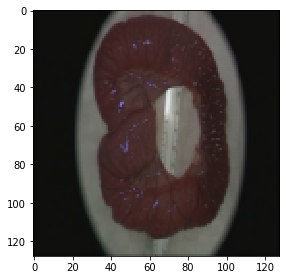

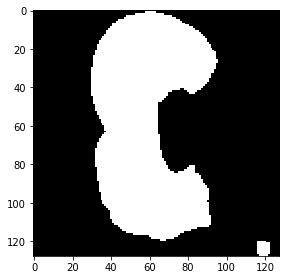

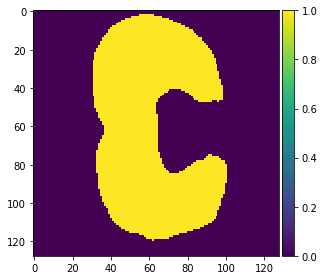

In [27]:
# Print the validation image set
# it's image set no. 7 => idx = 6
ix = 6

imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_val_t[0]))
plt.show()

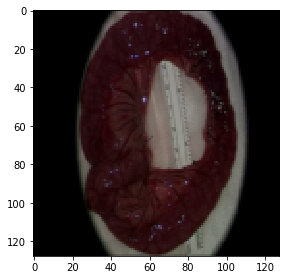

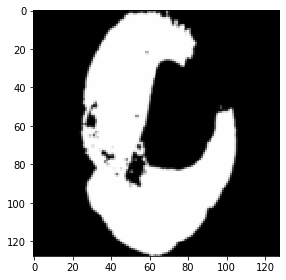

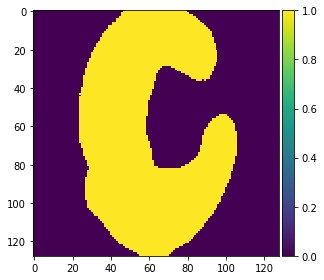

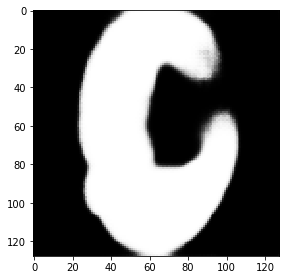

In [28]:
# Print example of prediction on test images
# test images also have masks to comparison

#for i in range(3):
# Fixed image
ix = 0

# Random image
#ix = random.randint(0, len(preds_test_t)-1)

imshow(np.squeeze(X_test[ix]))
plt.show()
imshow(np.squeeze(Y_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()
imshow(np.squeeze(preds_test[ix]))
plt.show()

In [30]:
# Gem et billede som er vist (tiltænkt til predictions)
# Definer x som det billede der skal gemmes
x = preds_test_t[0]

arr = np.squeeze(x)
new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255).astype('uint8'))
im = Image.fromarray(new_arr)
im.save("Billede.png")

OSError: cannot write mode F as PNG